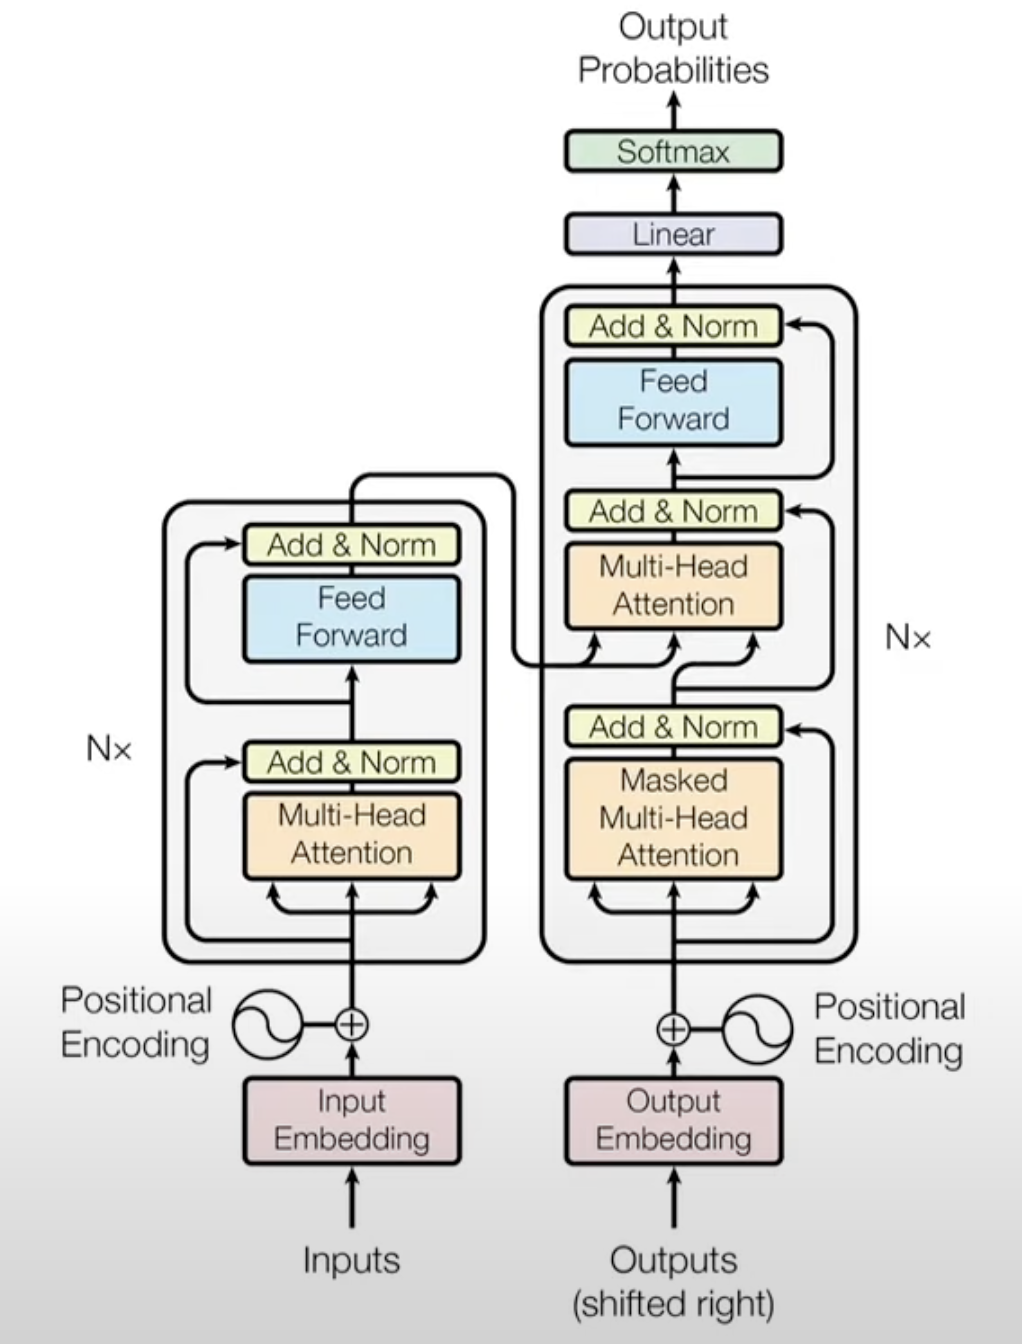

In [45]:
import torch
import torch.nn as nn
import math

print(f"torch version : {torch.__version__}")

torch version : 2.8.0


# 1. Input Embedding

In [43]:
# Input Embedding
class InputEmbedding(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

        def forward(self, x):
            return self.embedding(x) * math.sqrt(self.d_model)

# 2. Positional Encoding

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        self.pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

## What is register_buffer in PyTorch, and how it's different from register_parameter?

Both parameters and buffers you create for a module (nn.Module).

Say you have a linear layer nn.Linear. You already have weight and bias parameters. But if you need a new parameter you use register_parameter() to register a new named parameter that is a tensor.

When you register a new parameter it will appear inside the module.parameters() iterator, but when you register a buffer it will not.

**The difference:**

Buffers are named tensors that do not update gradients at every step, like parameters. For buffers, you create your custom logic (fully up to you).

The good thing is when you save the model, all params and buffers are saved, and when you move the model to or off the CUDA params and buffers will go as well.

# 3. Layer Normalization

In [ ]:
# Layer Normalization

class LayerNormalization(nn.Module):
    
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()

        self.eps = eps
        # nn.Parameter register a tensor as a learnable parameter within an nn.Module, then it will show up in model.parameters()
        self.alpha = nn.Parameter(torch.ones(1)) # Multiplied
        self.bias = nn.Parameter(torch.ones(1)) # Added

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)

        return self.alpha * (x-mean)/(std+self.eps) + self.bias

# 4. Feed Forward Layer

In [53]:
class FeedForwardLayer(nn.Module):

    def __init__(self, d_model: int, d_ff:int, dropout: float):
        super().__init__()

        self.fflayer = nn.Sequential(

            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)

        )

    def forward(self, x):
        return self.fflayer    


# 5. Multi Head Attention

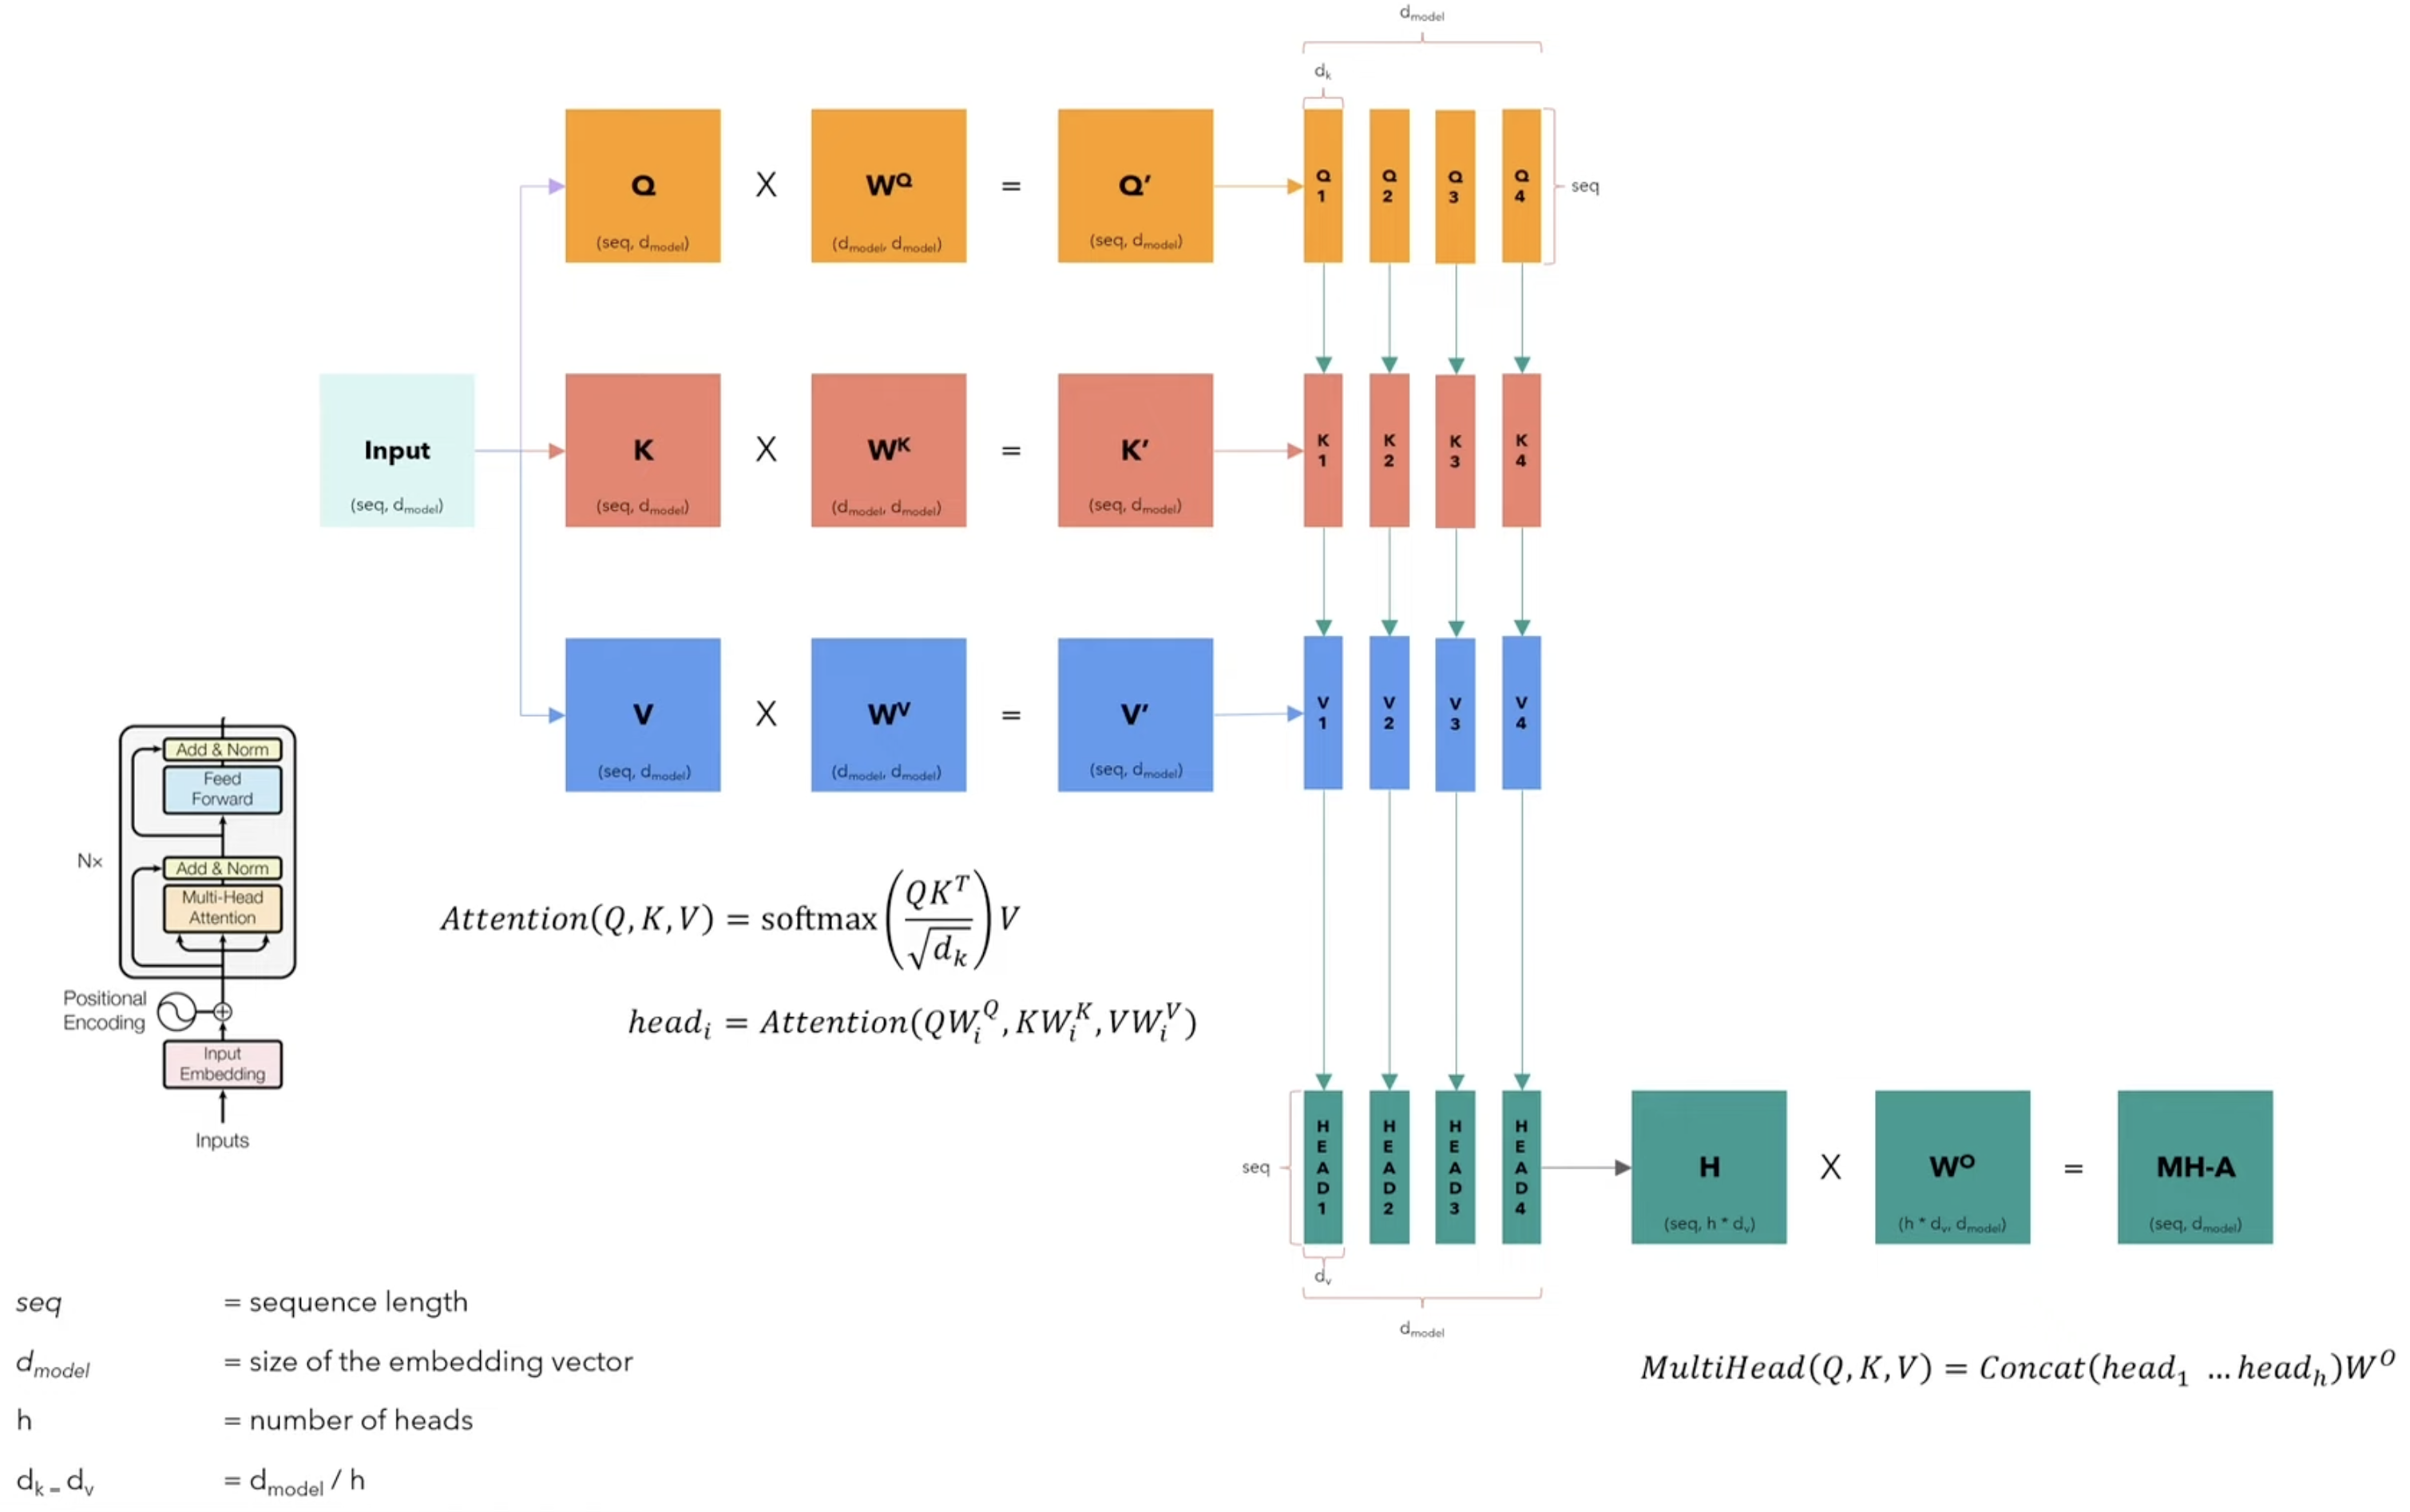

In [80]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()

        self.d_model = d_model
        self.h = h

        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model) # Wq
        self.w_k = nn.Linear(d_model, d_model) # Wk
        self.w_v = nn.Linear(d_model, d_model) # Wv

        self.w_o = nn.Linear(d_model, d_model) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q @ q
        key = self.w_k @ k
        value = self.w_v @ v

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o @ x

# 6. Residual Connection

In [ ]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

# 7. Encoder

In [81]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardLayer, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [82]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# 8. Decoder

In [84]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardLayer, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x
    
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)


In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbedding, tgt_embed: InputEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)
    
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbedding(d_model, src_vocab_size)
    tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForwardLayer(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForwardLayer(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

# End